In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

calendar = pd.read_csv("./Seattle/calendar.csv", parse_dates= ['date'])
listings = pd.read_csv("./Seattle/listings.csv")
reviews = pd.read_csv("./Seattle/reviews.csv")

pd.set_option('display.max_rows', 100)

### BUSINESS UNDERSTANDING

Here are the following questions I'd like to explore:
How do prices vary by neighborhood?
How do prices vary by time of year and day of week?
How well do neighborhood, time, and basic listing characteristics explain the variation in prices?

### DATA UNDERSTANDING

In [2]:
# Format price variable
calendar['price'] = calendar['price'].str.replace('[\$\,]', '', regex=True)
calendar['price'].head()
calendar['price'] = calendar['price'].astype(float)

# Create new time variables
calendar['month'] = pd.DatetimeIndex(calendar['date']).month
calendar['dayofweek'] = calendar['date'].dt.day_name()

# Merge in variables from listings dataframe
calendar = calendar.merge(listings[['id', 'neighbourhood_group_cleansed', 'review_scores_value', 'bedrooms', 'bathrooms', 'property_type', 'availability_365', 'reviews_per_month']], left_on = 'listing_id', right_on = 'id')



Some observations are dropped due to missing values. I drop observations when bedrooms or bathrooms are null because this is essential information that is missing and only a very small percentage of observations is affected.

I drop observations when price is missing because price is only missing when the listing is not available. I'm only interested in available listings for this analysis.

In [4]:
# Show extent to which data is missing 
print(calendar['bedrooms'].isna().sum()/calendar['bedrooms'].shape[0])
print(calendar['bathrooms'].isna().sum()/calendar['bathrooms'].shape[0])
print(calendar['price'].isna().sum()/calendar['price'].shape[0])
print(calendar[(calendar['price'].isna()==True) & (calendar['available'] =='t')].sum())

# Drop NA values
calendar = calendar.dropna(subset=['price', 'bedrooms', 'bathrooms'])


0.0
0.0
0.0
listing_id                      0.0
available                       0.0
price                           0.0
month                           0.0
dayofweek                       0.0
id                              0.0
neighbourhood_group_cleansed    0.0
review_scores_value             0.0
bedrooms                        0.0
bathrooms                       0.0
property_type                   0.0
availability_365                0.0
reviews_per_month               0.0
dtype: float64


In [6]:
# Understand time period covered
print(calendar['date'].min())
print(calendar['date'].max())

# Understand basic summary statistics about prices
print(calendar['price'].describe().round(0))

# Percentage of listings priced at $500 or more
print(len(calendar['price'][calendar['price'] >= 500])/len(calendar['price']))

2016-01-04 00:00:00
2017-01-02 00:00:00
count    927736.0
mean        138.0
std         105.0
min          10.0
25%          75.0
50%         109.0
75%         160.0
max        1650.0
Name: price, dtype: float64
0.014610837565859253


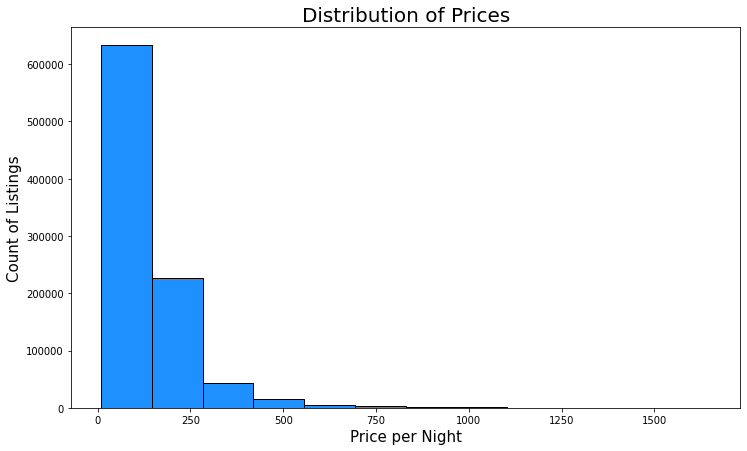

In [7]:
#Price Distribution
fig, ax = plt.subplots(figsize=(12, 7))
ax.hist(calendar['price'], bins=12, ec='black', color = 'dodgerblue')
ax.set_xlabel('Price per Night', fontsize = 15)
ax.set_ylabel('Count of Listings', fontsize = 15)
ax.set_title('Distribution of Prices', fontsize=20);

<ipython-input-8-592bf2c651cd>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(listings_neighborhood.index, rotation=90, ha='right', fontsize = 15)


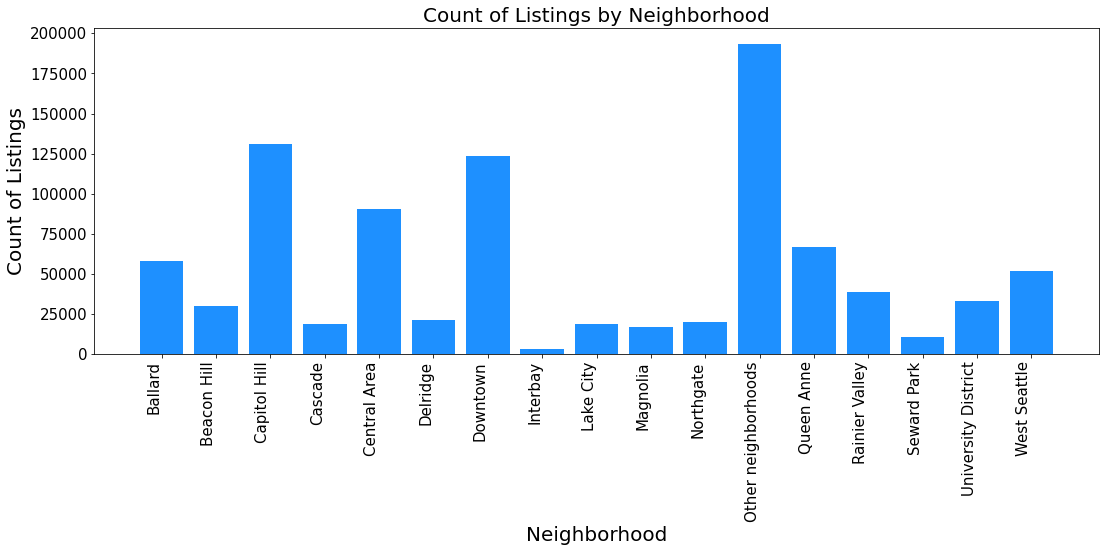

In [8]:
#Number of available listings by neighborhood 
listings_neighborhood = calendar.groupby('neighbourhood_group_cleansed')['listing_id'].count()

fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(listings_neighborhood.index, listings_neighborhood.values, color = 'dodgerblue')
ax.set_xlabel("Neighborhood", fontsize=20)
ax.set_xticklabels(listings_neighborhood.index, rotation=90, ha='right', fontsize = 15)
ax.set_ylabel("Count of Listings", fontsize=20)
ax.set_title('Count of Listings by Neighborhood', fontsize=20);
ax.tick_params(axis="y", labelsize=15);

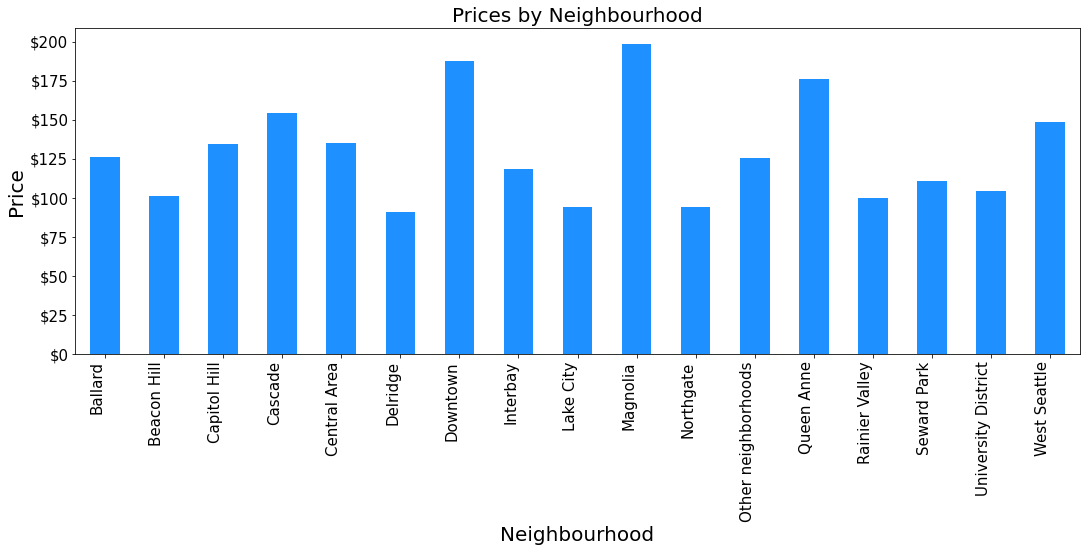

In [9]:
# Price by neighborhood
avg_price_neighborhood = calendar.groupby('neighbourhood_group_cleansed')['price'].mean()

ax = avg_price_neighborhood.plot(kind='bar', figsize=(18, 6), fontsize=12, color = 'dodgerblue')
ax.set_xlabel("Neighbourhood", fontsize=20)
ax.set_xticklabels(listings_neighborhood.index, rotation=90, ha='right', fontsize = 15)
ax.set_ylabel("Price", fontsize=20)
ax.set_title('Prices by Neighbourhood', fontsize=20)
tick = mtick.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(tick)
ax.tick_params(axis="y", labelsize=15);

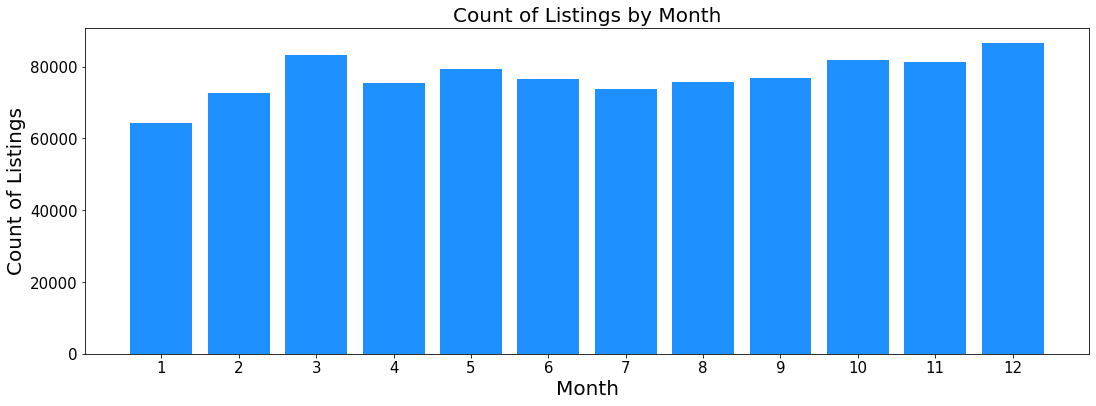

In [10]:
listings_month = calendar.groupby('month')['listing_id'].count()

fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(listings_month.index, listings_month.values, color = 'dodgerblue')
ax.set_xlabel("Month", fontsize=20)
ax.set_xticks(np.arange(min(listings_month.index), max(listings_month.index)+1, 1))
ax.set_xticklabels(np.arange(min(listings_month.index), max(listings_month.index)+1, 1), fontsize = 15)
ax.set_ylabel("Count of Listings", fontsize=20)
ax.tick_params(axis="y", labelsize=15);
ax.set_title('Count of Listings by Month', fontsize=20);


In [11]:
np.arange(min(listings_month.index), max(listings_month.index)+1, 1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

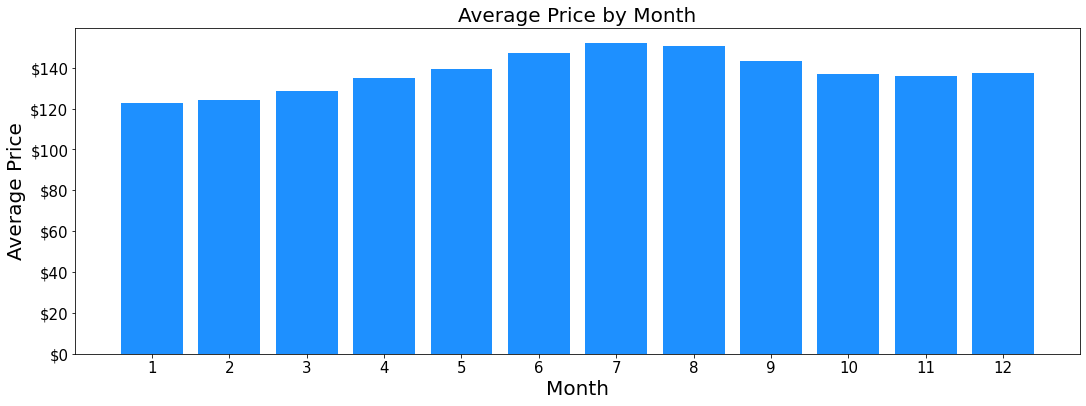

In [12]:
# Price by month
avg_price_month = calendar.groupby('month')['price'].mean()

fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(avg_price_month.index, avg_price_month.values, color = 'dodgerblue')
ax.set_xlabel("Month", fontsize=20)
ax.set_ylabel("Average Price", fontsize=20)
ax.set_xticks(np.arange(min(avg_price_month.index), max(avg_price_month.index)+1, 1))
ax.set_xticklabels(np.arange(min(avg_price_month.index), max(avg_price_month.index)+1, 1), fontsize = 15)
ax.set_title('Average Price by Month', fontsize=20)
ax.tick_params(axis="y", labelsize=15);

tick = mtick.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(tick);

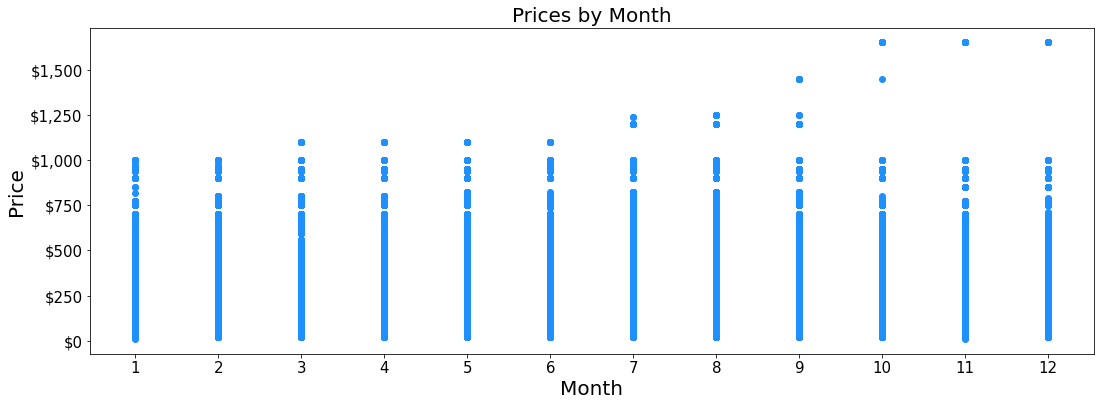

In [13]:
# Distribution of Prices by month
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter(x=calendar['month'], y=calendar['price'], color = 'dodgerblue')
ax.set_xlabel('Month', fontsize=20)
ax.set_xticks(np.arange(min(avg_price_month.index), max(avg_price_month.index)+1, 1))
ax.set_xticklabels(np.arange(min(avg_price_month.index), max(avg_price_month.index)+1, 1), fontsize = 15)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel('Price', fontsize=20)
ax.set_title('Prices by Month', fontsize=20)
tick = mtick.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(tick);

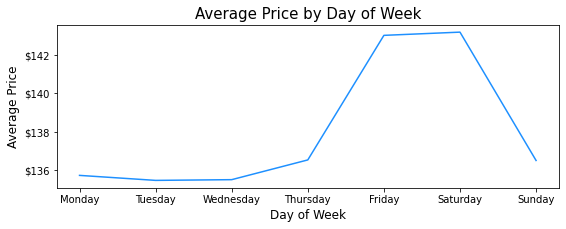

In [14]:
# Price by day of week
avg_price_dayofweek = calendar.groupby('dayofweek')['price'].mean()

fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(avg_price_dayofweek[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']], color = 'dodgerblue')
ax.set_xlabel("Day of Week", fontsize=12)
ax.set_ylabel("Average Price", fontsize=12)
ax.set_title('Average Price by Day of Week', fontsize=15)
tick = mtick.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(tick);

### PREPARE DATA

I would like to incorporate categorical variables into the model, and in order to do that I need to transform the categorical variables into dummy variables

In [15]:
# Generate dummy variables 
calendar.rename(columns={'neighbourhood_group_cleansed': 'neighborhood'}, inplace=True)
calendar = pd.get_dummies(calendar, columns = ['neighborhood', 'dayofweek', 'property_type', 'month']) 

There are some quantitative variables that have missing values. In order to incorporate these into a model, I will impute values for this missing data because I don't want to drop the observations, which would throw away information and potentially bias the results (if the data is missing for non-random reasons). 

In [16]:
# Calculate percentage of rows with missing data
print(calendar['review_scores_value'].isna().sum()/calendar.shape[0])
print(calendar['availability_365'].isna().sum()/calendar.shape[0])
print(calendar['reviews_per_month'].isna().sum()/calendar.shape[0])


0.15625026947321222
0.0
0.148976648529323


One method for imputation is to model and predict values based on other data, but this could introduce new biases (if my model is wrong). Instead, I will fill in missing values with the average because this will allow me to incorporate those observations without biasing the results.

In [17]:
#Impute missing review scores

def mean_fill(df, missing_vars):
    '''
    INPUT
    df - pandas dataframe
    missing_vars - list containing column names with missing values
    
    OUTPUT
    dataframe with missing values in specified columns filled with the column's mean
    
    This function uses the fill_na function to iteratively imput the mean value for specified columns
    '''
    
    for col in missing_vars:
        df[col].fillna((df[col].mean()), inplace=True)
    
    return df


calendar = mean_fill(calendar, missing_vars = ['review_scores_value', 'availability_365', 'reviews_per_month'])

### MODEL DATA

In [18]:
X = calendar.drop(columns=['listing_id', 'date', 'available', 'price', 'id'])
y = calendar['price']

# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.30, random_state=42)
lm_model = LinearRegression(normalize=True)

lm_model.fit(X_train, y_train)

LinearRegression(normalize=True)

### RESULTS

In [19]:
y_test_preds = lm_model.predict(X_test) 
rsquared_score = r2_score(y_test, y_test_preds)

In [20]:
rsquared_score

0.5381497162814579

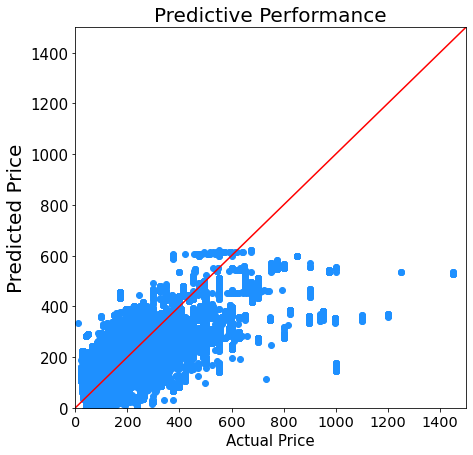

In [21]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x= y_test, y=y_test_preds, color = 'dodgerblue')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_xlim([0, 1500])
ax.set_ylim([0, 1500])
ax.set_xlabel("Actual Price", fontsize=15)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel('Predicted Price', fontsize=20)
ax.set_title('Predictive Performance', fontsize=20)
ax.xaxis.set_tick_params(labelsize='x-large')


#tick = mtick.StrMethodFormatter('${x:,.0f}')
plt.show()

Here is a link to the post: https://andrew-lee.medium.com/making-sense-of-airbnb-prices-in-seattle-87f4a2a1f51e